In [65]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

In [66]:
import json
with open('placement_interview_task_data.json') as json_file:
    file_contents = json_file.read()

    parsed_json = json.loads(file_contents)

num_samples = len(parsed_json)

X = np.zeros((num_samples, 50, 1))
Y = np.zeros((num_samples, 1))

for i, identifier in enumerate(parsed_json):
    sales_values = list(parsed_json[identifier].values())
    X[i, :, 0] = sales_values[:50]
    Y[i, 0] = sales_values[50]

X_train, X_val, X_test = X[:int(0.7 * len(X))], X[int(0.7 * len(X)):int(0.8 * len(X))], X[int(0.8 * len(X)) :]
y_train, y_val, y_test = Y[:int(0.7 * len(Y))], Y[int(0.7 * len(Y)):int(0.8 * len(Y))], Y[int(0.8 * len(Y)) :]


In [73]:
# Reshape Y to have
Y12 = np.zeros((num_samples, 12))
y12_train, y12_val, y12_test = Y12[:int(0.7 * len(Y))], Y12[int(0.7 * len(Y)):int(0.8 * len(Y))], Y12[int(0.8 * len(Y)) :]

np.random.seed(40)
tf.random.set_seed(40)

model12 = tf.keras.models.Sequential([
    # This layer gives the model input parameters i.e. 50 months input and 1 feature per month inputted
    tf.keras.layers.Input(shape=[50, 1]),
    # Introduce a normalisation to scale the data between -1 and 1
    tf.keras.layers.Normalization(axis=-1),
     # This LSTM layer (Long Short-Term Memory) is well suited for processing sequential times series
    # Return sequences is set to true to return all 50 values and has a dropout parameter to drop 20%
    # of activations during training.
    tf.keras.layers.LSTM(units=64, return_sequences=True, dropout=0.2),
    # This bidirectional layer will process the data both forwards and backwards
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32, dropout=0.1)),
    # 32 output neuron layer to try and extract hidden features
    tf.keras.layers.Dense(32, activation='elu'),
    # Regression activation layer that is suited to predict the value of each future 12 predictions
    tf.keras.layers.Dense(1, activation='linear')
])

def last_time_step_mse12(Y12_true, Y12_pred):
    return tf.keras.metrics.mean_squared_error(Y12_true[:, -1], Y12_pred[:, -1])

model12.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
              metrics=[last_time_step_mse12])

# Train the model (using validation data)
history12 = model12.fit(X_train, y_train, epochs=10, validation_data=(X_val, y12_val))

# Evaluate the model after training
model_mse_loss12 = model12.evaluate(X_val, y12_val)

# Make predictions on the test data
y12_pred = model12.predict(X_test)



Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - last_time_step_mse12: 0.0592 - loss: 0.0592 - val_last_time_step_mse12: 0.0997 - val_loss: 0.0997
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - last_time_step_mse12: 0.0338 - loss: 0.0338 - val_last_time_step_mse12: 0.0939 - val_loss: 0.0939
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - last_time_step_mse12: 0.0328 - loss: 0.0328 - val_last_time_step_mse12: 0.0918 - val_loss: 0.0918
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - last_time_step_mse12: 0.0314 - loss: 0.0314 - val_last_time_step_mse12: 0.0952 - val_loss: 0.0952
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - last_time_step_mse12: 0.0317 - loss: 0.0317 - val_last_time_step_mse12: 0.0968 - val_loss: 0.0968
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - last_time_step_mse12: 0.0311 - loss: 0.0311 - val_last_time_step_mse12: 0.0923 - val_loss: 0.0923
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - last_time_step_mse12

In [68]:
# Print a message based on the validation loss
if model_mse_loss12[0] < 0.004168:
  print("The model achieved a validation MSE loss less than 0.004168!")
else:
  print(f"The model's validation MSE loss is {model_mse_loss12[0]:.4f}.")
  print("This is not less than the target threshold of 0.004168. Consider training for more epochs or adjusting hyperparameters.")

The model's validation MSE loss is 0.1019.
This is not less than the target threshold of 0.004168. Consider training for more epochs or adjusting hyperparameters.


In [69]:
import csv


# Function to create the CSV file
def create_csv_file(data, filename="predicted_sales.csv"):
  # Create directory for output files if it doesn't exist
  create_dir("images")  # Assuming you want images in a separate folder

  with open(os.path.join("images", filename), 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)

    # Header row with relevant information
    header = ["Store ID", *[f"Month {i+1}" for i in range(63)], "Average Sales (1-63)",
               *[f"Predicted Month {i+64}" for i in range(12)]]
    csv_writer.writerow(header)

    for i, identifier in enumerate(parsed_json):
      sales_data = data[i]
      average_sales = np.mean(sales_data[:64])
      predicted_values = y12_pred[:12]
      row_data = [identifier, *sales_data[:63], average_sales, *predicted_values]
      csv_writer.writerow(row_data)

# Helper function to create directory if it doesn't exist
def create_dir(directory):
  if not os.path.exists(directory):
    os.makedirs(directory)

# Get sales data for all stores in the test set
all_sales_data = []
for identifier in parsed_json:
    all_sales_data.append(list(parsed_json[identifier].values()))

# Create the CSV file
create_csv_file(all_sales_data)

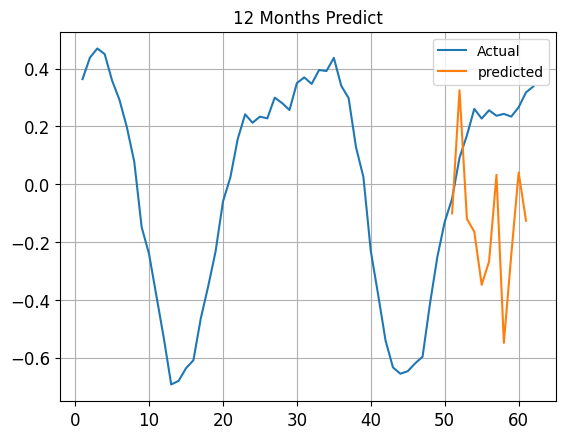

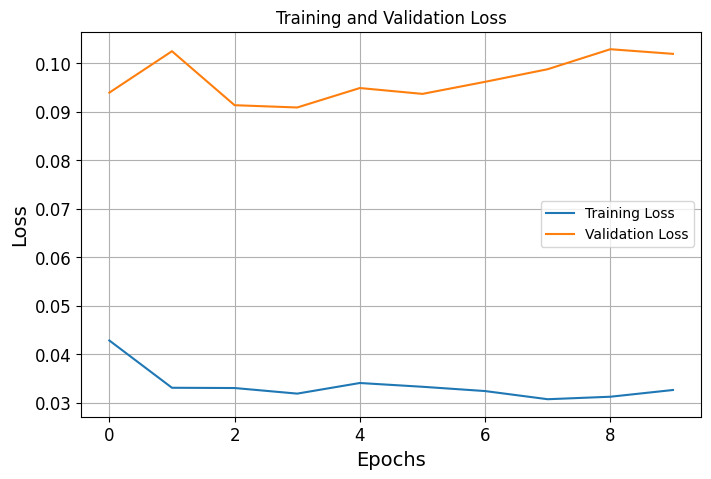

In [70]:
# Function to plot actual first 50 months sales and the next 12 months
def plotTwelveMonthsPredicted(x):
    x_axis = np.arange(1, 63)
    x1_axis = np.arange(51, 62)
    plt.plot(x_axis, x, label='Actual')
    predictedNextTwelveMonths = y12_pred[1:12]
    plt.plot(x1_axis, predictedNextTwelveMonths, label='predicted')
    plt.grid(True)
    plt.legend()
    plt.title("12 Months Predict")
    plt.savefig('images/plotTwelveMonthsPredicted6..png')
    plt.show()


# Function to plot loss curves
def plot_loss_curves(history):
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs_range = range(len(train_loss))
  plt.figure(figsize=(8, 5))
  plt.plot(epochs_range, train_loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.savefig('images/plot_loss_curves12.png')
  plt.show()



all_sales_data = []
for identifier in parsed_json:
    all_sales_data.append(list(parsed_json[identifier].values()))

plotTwelveMonthsPredicted(sales_values[:63])

plot_loss_curves(history12)

In [71]:
# Help reproduce same results, alter the number to change the results
np.random.seed(8)
tf.random.set_seed(8)

#
model = tf.keras.models.Sequential([
    # This layer gives the model input parameters i.e. 50 months input and 1 feature per month inputted
    tf.keras.layers.Input(shape=[50,1]),
    # This LSTM layer (Long Short-Term Memory) is well suited for processing sequential times series
    # Return sequences is set to true to return all 50 values
    tf.keras.layers.LSTM(units=64, return_sequences=True),
    # This bidirectional layer will process the data both forwards and backwards
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32)),
    # Performa a linear transformation on LSTM layers output
    tf.keras.layers.Dense(16, activation='elu'),
    # Final dense layer that has one output neuron
    tf.keras.layers.Dense(1)
])

# Provide extra information during training
def last_time_step_mse(Y_true, Y_pred):
    return tf.keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

# Compile the model
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
              metrics=[last_time_step_mse])

# Train the model (using validation data)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

# Evaluate the model after training
model_mse_loss = model.evaluate(X_val, y_val)

# Print a message based on the validation loss
if model_mse_loss[0] < 0.004168:
  print("The model achieved a validation MSE loss less than 0.004168!")
else:
  print(f"The model's validation MSE loss is {model_mse_loss:.4f}.")
  print("This is not less than the target threshold of 0.004168. Consider training for more epochs or adjusting hyperparameters.")

Epoch 1/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - last_time_step_mse: 0.0315 - loss: 0.0315 - val_last_time_step_mse: 0.0025 - val_loss: 0.0025
Epoch 2/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - last_time_step_mse: 0.0028 - loss: 0.0028 - val_last_time_step_mse: 0.0023 - val_loss: 0.0023
Epoch 3/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - last_time_step_mse: 0.0026 - loss: 0.0026 - val_last_time_step_mse: 0.0022 - val_loss: 0.0022
Epoch 4/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - last_time_step_mse: 0.0025 - loss: 0.0025 - val_last_time_step_mse: 0.0021 - val_loss: 0.0021
Epoch 5/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - last_time_step_mse: 0.0024 - loss: 0.0024 - val_last_time_step_mse: 0.0020 - val_loss: 0.0020
Epoch 6/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - last_time_step_mse: 0.0023 - loss: 0.0023 - val_last_time_step_mse: 0.0021 - val_loss: 0.0021
Epoch 7/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - last_time_step_mse: 0.0023 - loss: 0.0023 - 

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


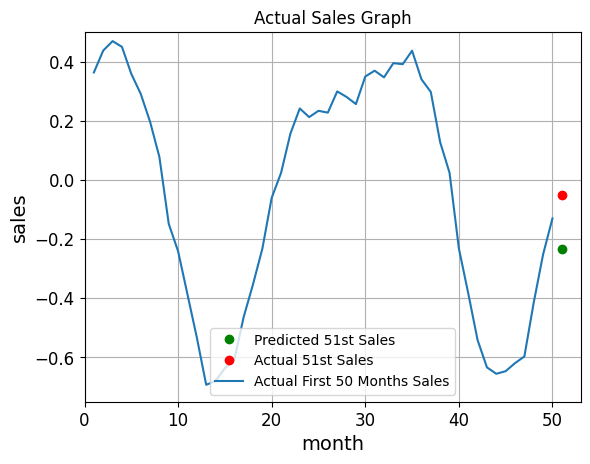

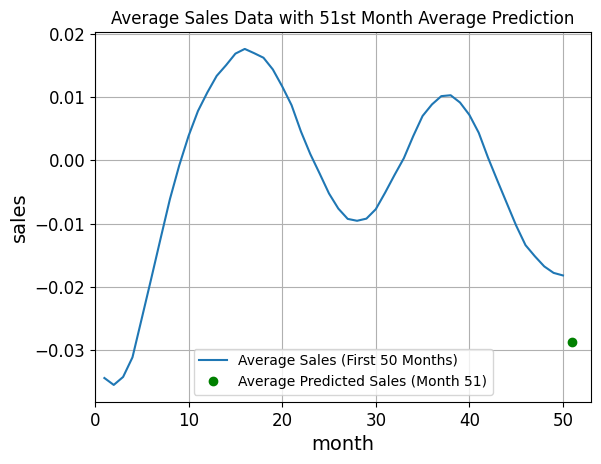

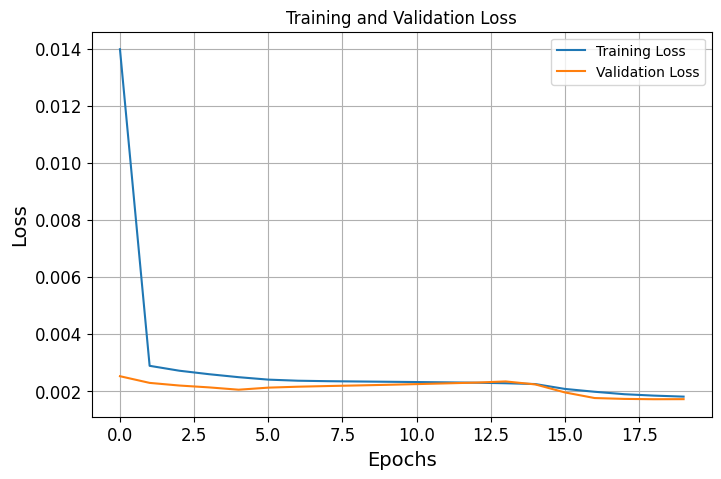

In [72]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Function to plot first 50 months actual sales, the predicted 51st sales and the actual 51st sales
def plotFirstFiftyMonthsSales(x):
    x_axis = np.arange(1, 51)
    plt.plot([51], y_pred[1], 'go', label='Predicted 51st Sales')  # Plot prediction at x=51
    plt.plot([51], sales_values[50], 'ro', label='Actual 51st Sales')
    plt.title('Actual Sales Graph')
    plt.plot(x_axis, x, label='Actual First 50 Months Sales')
    plt.grid()
    plt.xlabel('month')
    plt.ylabel('sales')
    plt.axis((0, 53, -0.75, .5))
    plt.legend(loc = 'lower center')
    plt.savefig('images/plotFirstFiftyMonthsSales.png')
    plt.show()

# Function to calculate average sales and plot with prediction
def plot_combined_sales_and_prediction(sales_data_list, predicted_values):
    average_sales = np.mean(sales_data_list, axis=0)[:50]
    x_axis = np.arange(1, 51)
    plt.plot(x_axis, average_sales, label='Average Sales (First 50 Months)')
    plt.plot([51], predicted_values.mean(), 'go', label='Average Predicted Sales (Month 51)')
    plt.xlabel('month')
    plt.ylabel('sales')
    plt.xlim(0, 53)  # Set x-axis from 0 to 53
    plt.title('Average Sales Data with 51st Month Average Prediction')
    plt.legend(loc = 'lower center')
    plt.grid()
    plt.savefig('images/plot_combined_sales_and_prediction.png')
    plt.show()

# Get sales data for all stores in the test set
all_sales_data = []
for identifier in parsed_json:
    all_sales_data.append(list(parsed_json[identifier].values()))
# Plot the training and validation loss
def plot_loss_curves(history):
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs_range = range(len(train_loss))
  plt.figure(figsize=(8, 5))
  plt.plot(epochs_range, train_loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.savefig('images/plot_loss_curves.png')
  plt.show()

# Plot the actual first 50 months
plotFirstFiftyMonthsSales(sales_values[:50])

# Plot the average sales and prediction in one graph
plot_combined_sales_and_prediction(all_sales_data, y_pred)

# Plot the loss graph
plot_loss_curves(history)


